## NASA Progpy Loading_Future Use examples

In [1]:
import matplotlib.pyplot as plt
from numpy.random import normal
from progpy.loading import Piecewise, GaussianNoiseLoadWrapper
from progpy.models import BatteryCircuit
from statistics import mean


In [2]:
m = BatteryCircuit()

# Simulate to threshold
options = {
    'save_freq': 100,  # Frequency at which results are saved
    'dt': 2  # Timestep
}

/Users/jonathanzha/Desktop/Meta-Learning-PINN-for-SOH/Meta-Learning/lib/python3.8/site-packages/progpy/exceptions.py:20: UserWarning: Behavior of SimResult.plot() will change with version 1.6. New behavior will match that of a pandas data frame.
  warn(msg, *args, **kwargs)


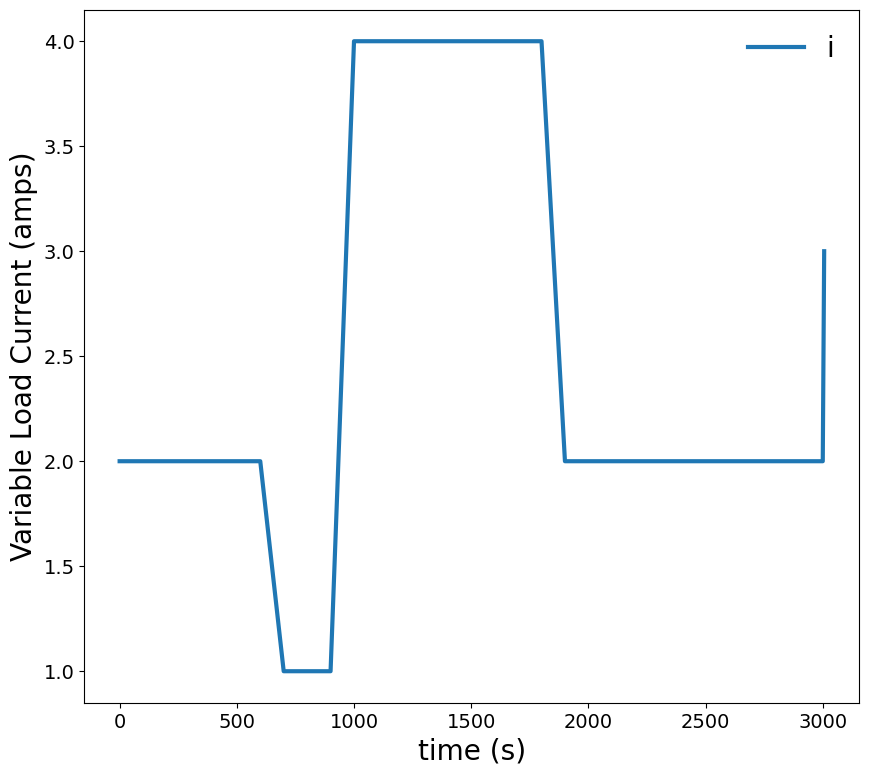

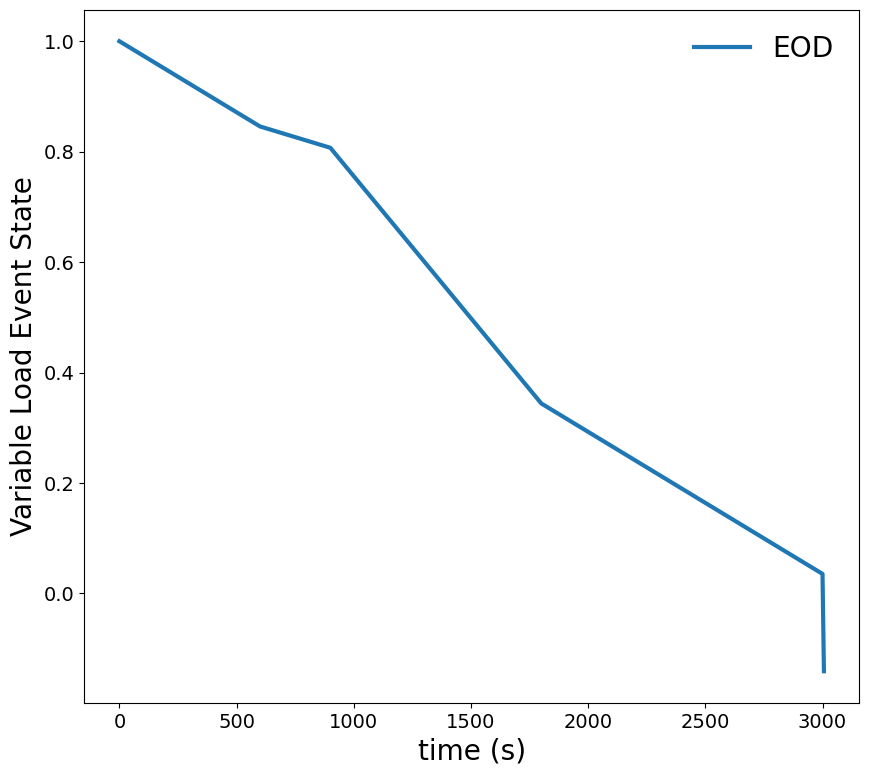

In [3]:
def run_example1():
    m = BatteryCircuit()
    ## Example 1: Variable (piecewise) loading
    future_loading = Piecewise(
        m.InputContainer,
        [600, 900, 1800, 3000, float('inf')],
        {'i': [2, 1, 4, 2, 3]})
    
    # Simulate to threshold
    options = {
        'save_freq': 100,  # Frequency at which results are saved
        'dt': 2  # Timestep
    }
    simulated_results = m.simulate_to_threshold(future_loading, **options)

    # Now lets plot the inputs and event_states
    simulated_results.inputs.plot(ylabel = 'Variable Load Current (amps)', xlabel='time (s)')
    simulated_results.event_states.plot(ylabel = 'Variable Load Event State', xlabel='time (s)')
    plt.show()

run_example1()

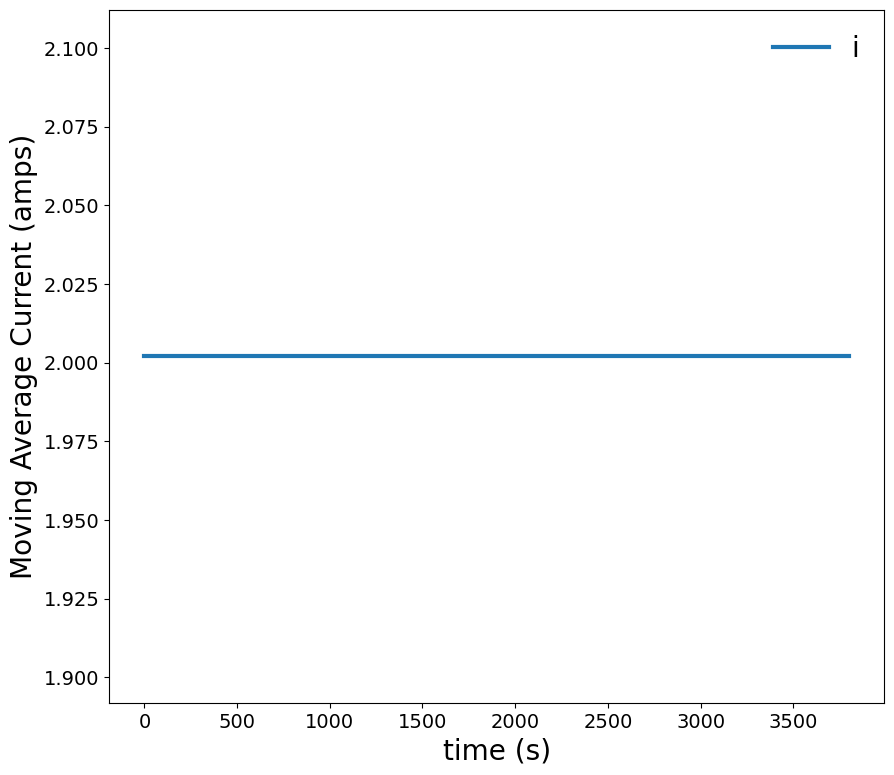

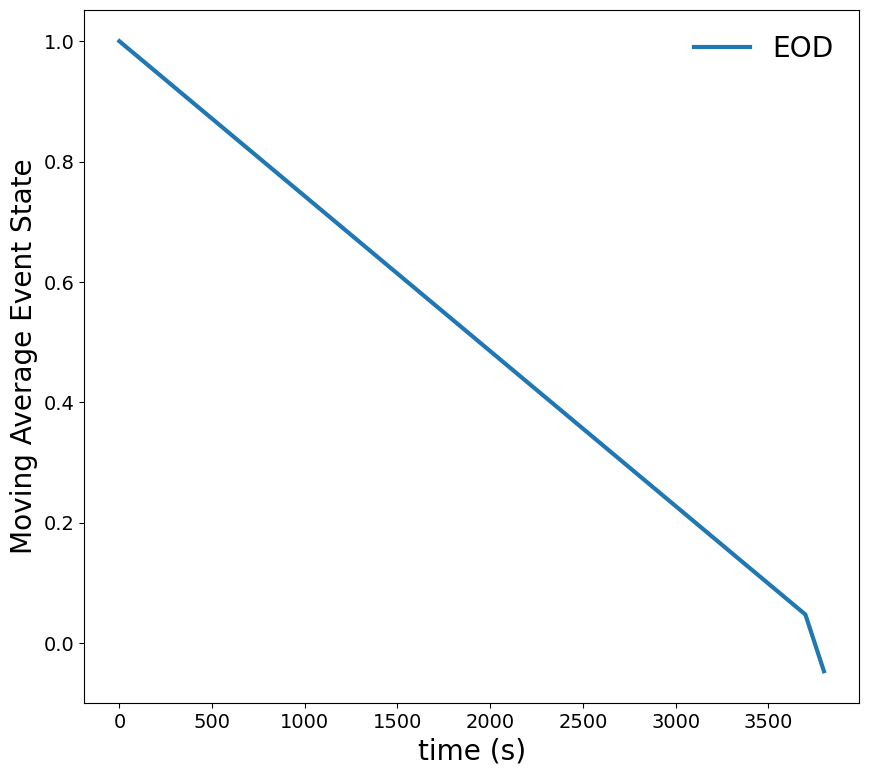

In [4]:
def run_example2():
    m = BatteryCircuit()
    from progpy.loading import MovingAverage
    options = {
    'save_freq': 100,  # Frequency at which results are saved
    'dt': 2  # Timestep
    }
    future_loading = MovingAverage(m.InputContainer)

    # Now lets say you have some measured loads to add
    measured_loads = [10, 11.5, 12.0, 8, 2.1, 1.8, 1.99, 2.0, 2.01, 1.89, 1.92, 2.01, 2.1, 2.2]
    
    # We're going to feed these into the future loading eqn
    for load in measured_loads:
        future_loading.add_load({'i': load})
    
    # Now the future_loading eqn is setup to use the moving average of whats been seen
    # Simulate to threshold
    simulated_results = m.simulate_to_threshold(future_loading, **options)

    # Now lets plot the inputs and event_states
    simulated_results.inputs.plot(ylabel = 'Moving Average Current (amps)', xlabel='time (s)')
    simulated_results.event_states.plot(ylabel = 'Moving Average Event State', xlabel='time (s)')
    plt.show()

run_example2()

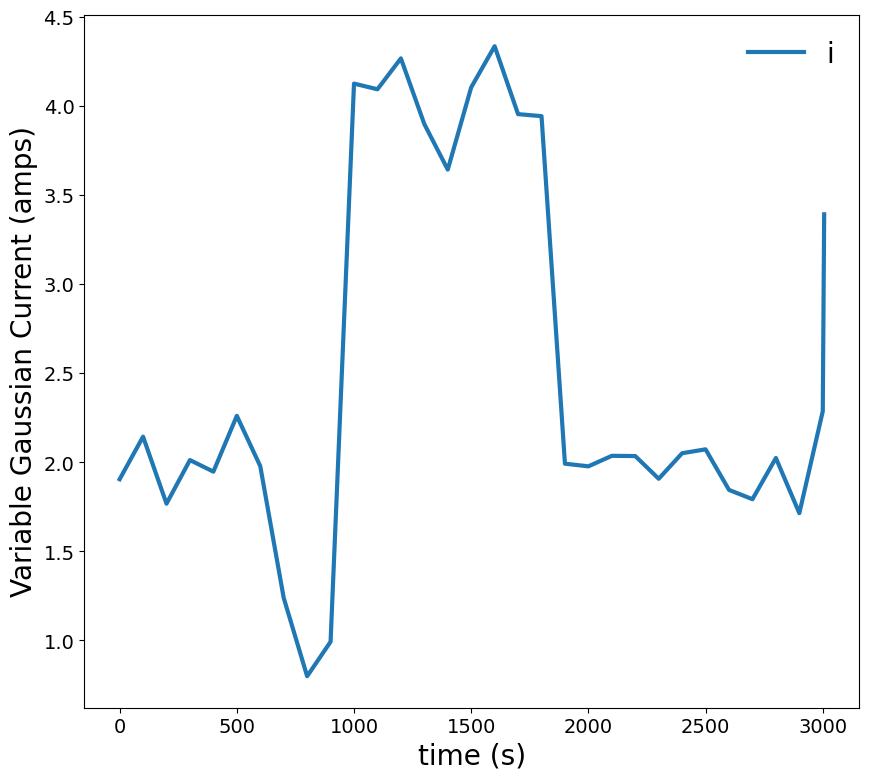

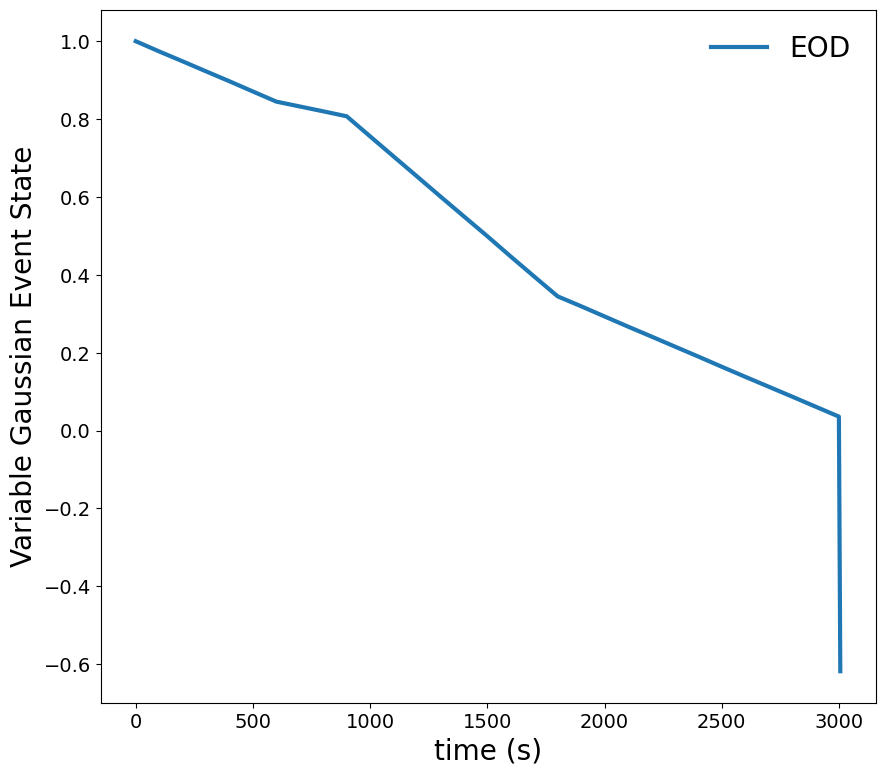

In [5]:
def run_example3():
     ## Example 3: Gaussian Distribution 
    # In this example we will still be doing a variable loading like the first option, but we are going to use a 
    # gaussian distribution for each input.
    future_loading = Piecewise(
        m.InputContainer,
        [600, 900, 1800, 3000, float('inf')],
        {'i': [2, 1, 4, 2, 3]})
    future_loading_with_noise = GaussianNoiseLoadWrapper(future_loading, 0.2)

    # Simulate to threshold
    simulated_results = m.simulate_to_threshold(future_loading_with_noise, **options)

    # Now lets plot the inputs and event_states
    simulated_results.inputs.plot(ylabel = 'Variable Gaussian Current (amps)', xlabel='time (s)')
    simulated_results.event_states.plot(ylabel = 'Variable Gaussian Event State', xlabel='time (s)')
    plt.show()

run_example3()

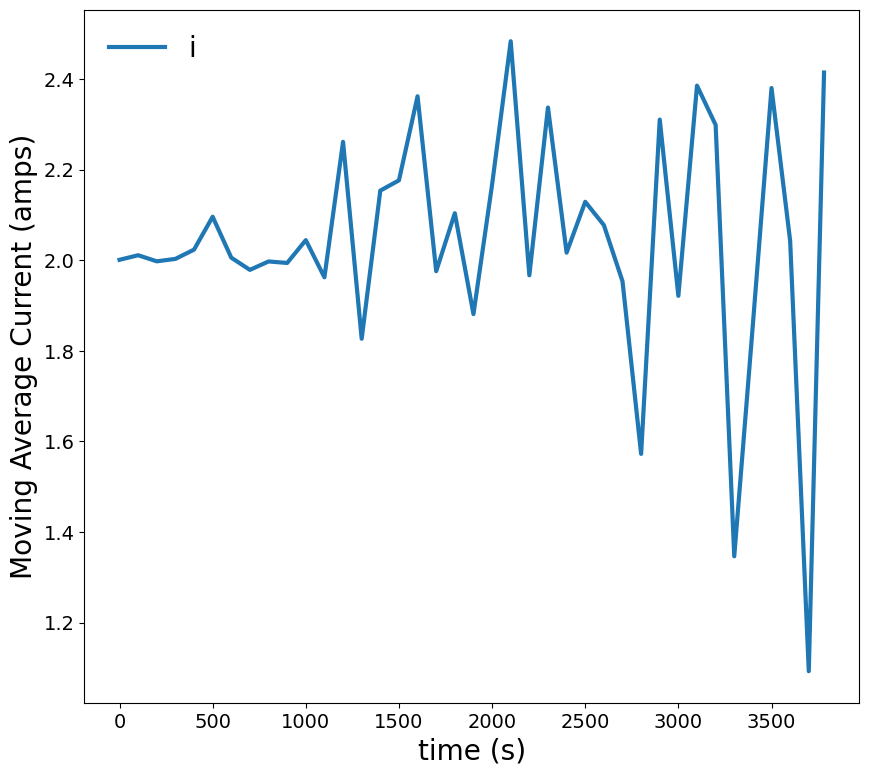

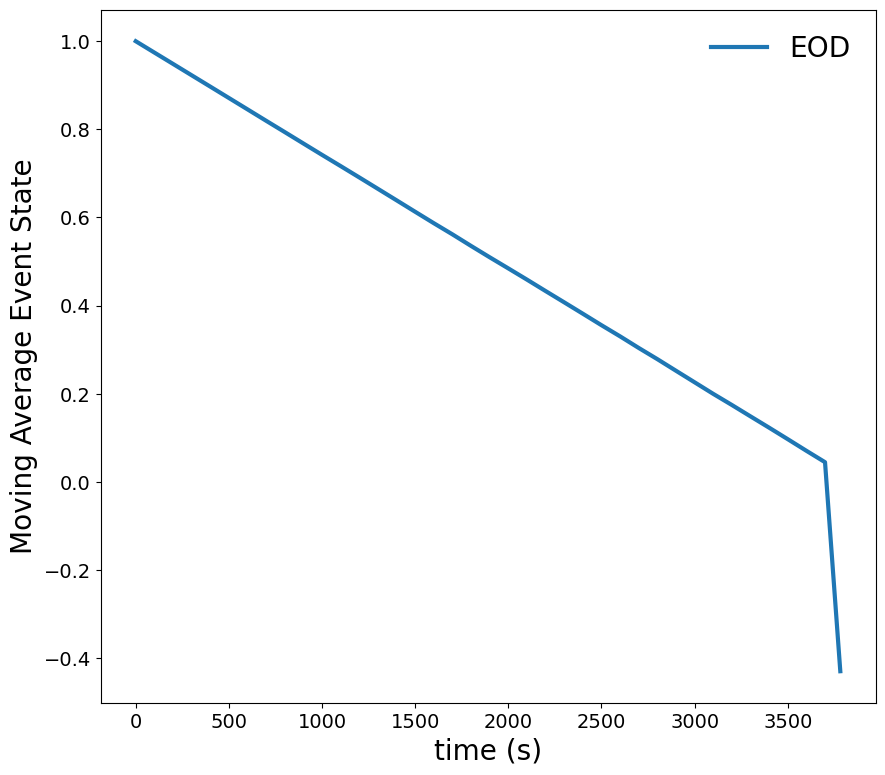

In [6]:
# Example 4: Gaussian- increasing with time
    # For this we're using moving average. This is realistic because the further out from current time you get, 
    # the more uncertainty there is in your prediction. 
def run_example_4():
    def future_loading(t, x=None):
        std = future_loading.base_std + future_loading.std_slope * (t - future_loading.t)
        return {key : normal(future_loading.load[key], std) for key in future_loading.load.keys()}
    future_loading.load = {key : 0 for key in m.inputs} 
    future_loading.base_std = 0.001
    future_loading.std_slope = 1e-4
    future_loading.t = 0

    # Lets define another function to handle the moving average logic
    window = 10  # Number of elements in window
    def moving_avg(i):
        for key in m.inputs:
            moving_avg.loads[key].append(i[key])
            if len(moving_avg.loads[key]) > window:
                del moving_avg.loads[key][0]  # Remove first item

        # Update future loading eqn
        future_loading.load = {key : mean(moving_avg.loads[key]) for key in m.inputs} 
    moving_avg.loads = {key : [] for key in m.inputs} 

    # OK, we've setup the logic of the moving average. 
    # Now lets say you have some measured loads to add
    measured_loads = [10, 11.5, 12.0, 8, 2.1, 1.8, 1.99, 2.0, 2.01, 1.89, 1.92, 2.01, 2.1, 2.2]
    
    # We're going to feed these into the future loading eqn
    for load in measured_loads:
        moving_avg({'i': load})

    # Simulate to threshold
    simulated_results = m.simulate_to_threshold(future_loading, **options)

    # Now lets plot the inputs and event_states
    simulated_results.inputs.plot(ylabel = 'Moving Average Current (amps)', xlabel='time (s)')
    simulated_results.event_states.plot(ylabel = 'Moving Average Event State', xlabel='time (s)')
    plt.show()

run_example_4()
    

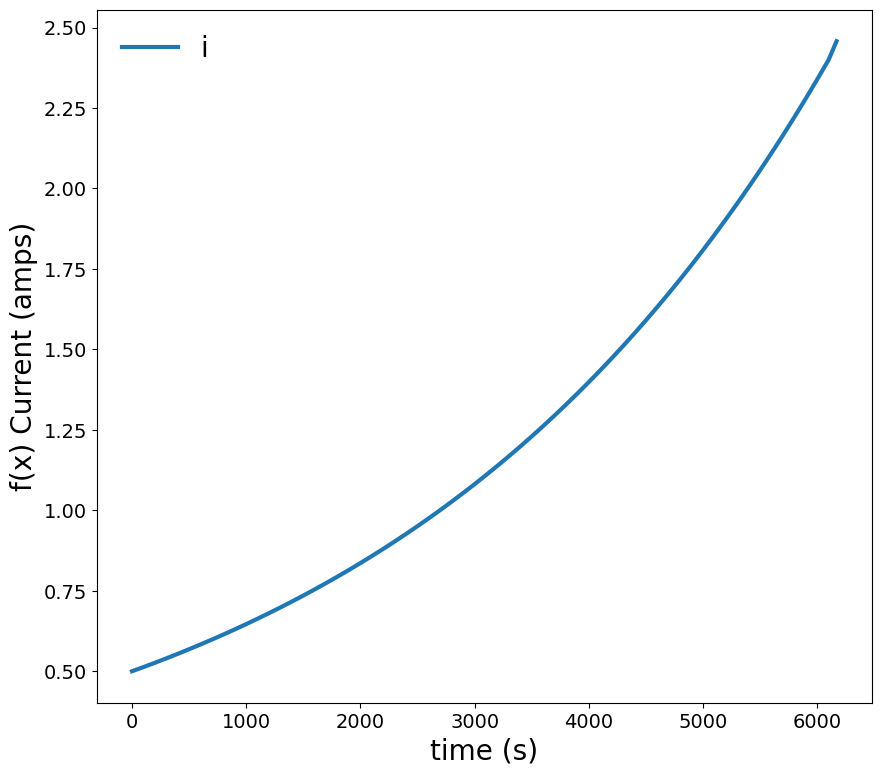

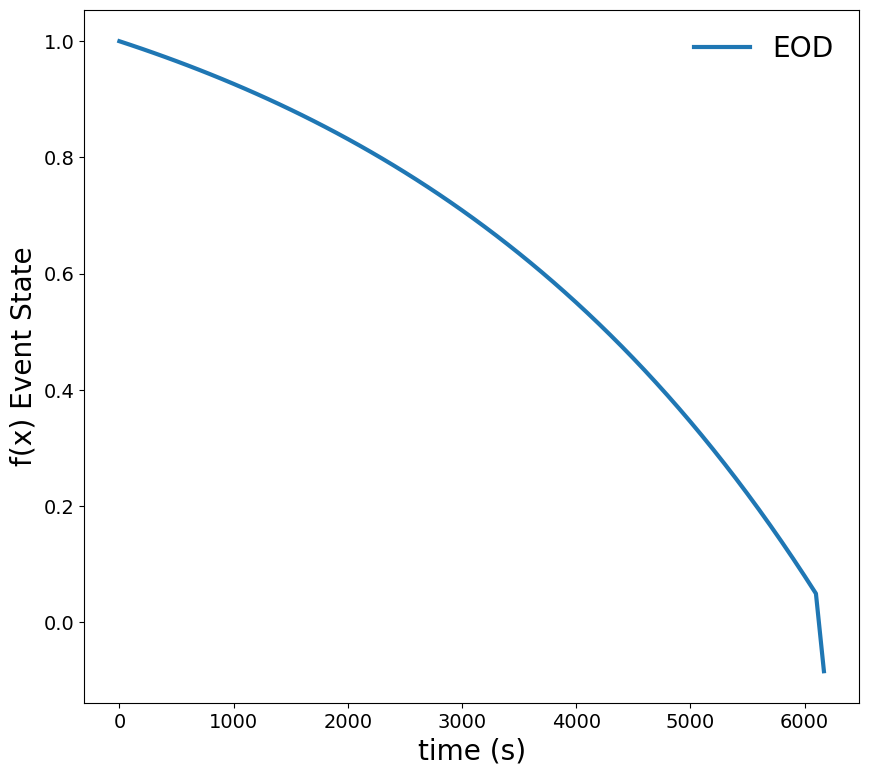

In [7]:
# Example 5 Function of state
    # here we're pretending that input is a function of SOC. It increases as we approach SOC
def run_example_5():
    def future_loading(t, x=None):
        if x is not None:
            event_state = future_loading.event_state(x)
            return m.InputContainer({'i': future_loading.start + (1-event_state['EOD']) * future_loading.slope})  # default
        return m.InputContainer({'i': future_loading.start})
    future_loading.t = 0
    future_loading.event_state = m.event_state
    future_loading.slope = 2  # difference between input with EOD = 1 and 0. 
    future_loading.start = 0.5

    # Simulate to threshold
    simulated_results = m.simulate_to_threshold(future_loading, **options)

    # Now lets plot the inputs and event_states
    simulated_results.inputs.plot(ylabel = 'f(x) Current (amps)', xlabel='time (s)')
    simulated_results.event_states.plot(ylabel = 'f(x) Event State', xlabel='time (s)')
    plt.show()

run_example_5()